### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
ls /ihme/costeffectiveness/results/vivarium_nih_us_cvd/model_9/alabama/2022_12_09_07_16_15/count_data/

deaths.csv                       risk_exposure_time.hdf
deaths.hdf                       sbp_medication_person_time.csv
healthcare_visits.csv            sbp_medication_person_time.hdf
healthcare_visits.hdf            state_person_time.csv
intervention_person_time.csv     state_person_time.hdf
intervention_person_time.hdf     transition_count.csv
ldlc_medication_person_time.csv  transition_count.hdf
ldlc_medication_person_time.hdf  ylds.csv
population.csv                   ylds.hdf
population.hdf                   ylls.csv
risk_exposure_time.csv           ylls.hdf


In [3]:
sim_results_dir = '/ihme/costeffectiveness/results/vivarium_nih_us_cvd/model_9/alabama/2022_12_09_07_16_15/count_data/'

### Exploring Data

In [4]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
deaths.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,age,value
0,0,female,2023,acute_ischemic_stroke,deaths,29,polypill_100,25_to_29,2.0
1,1,female,2023,acute_ischemic_stroke,deaths,29,polypill_50,25_to_29,2.0
2,2,female,2023,acute_ischemic_stroke,deaths,29,polypill_100,30_to_34,1.0
3,3,female,2023,acute_ischemic_stroke,deaths,29,polypill_50,30_to_34,1.0
4,4,female,2023,acute_ischemic_stroke,deaths,29,polypill_100,35_to_39,0.0


In [5]:
pop = pd.read_csv(sim_results_dir + 'population.csv')
pop.loc[pop.measure=="total_population_untracked"].value.sum()
pop.head()

,Unnamed: 0,measure,input_draw,scenario,value
0,0,total_population,29,polypill_100,750000.0
1,1,total_population,29,polypill_50,750000.0
2,2,total_population,232,polypill_100,750000.0
3,3,total_population,232,polypill_50,750000.0
4,4,total_population,357,polypill_100,750000.0


In [6]:
tran = pd.read_csv(sim_results_dir + 'transition_count.csv')
tran.transition.unique()

array(['ischemic_stroke_acute_ischemic_stroke_to_chronic_ischemic_stroke',
       'ischemic_stroke_chronic_ischemic_stroke_to_acute_ischemic_stroke',
       'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke',
       'myocardial_infarction_acute_myocardial_infarction_to_post_myocardial_infarction',
       'myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction',
       'myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction'],
      dtype=object)

In [7]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
#person_time = state_person_time.loc[state_person_time['scenario'].isin(["baseline"])].reset_index() 
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_stroke_acute_ischemic_stroke", "ischemic_stroke_chronic_ischemic_stroke", "ischemic_stroke_susceptible_to_ischemic_stroke"])].reset_index() 
person_time.value.sum()

204814157.83162215

In [8]:
person_time_test = state_person_time.loc[state_person_time['state'].isin(["myocardial_infarction_acute_myocardial_infarction", "myocardial_infarction_post_myocardial_infarction", "myocardial_infarction_susceptible_to_myocardial_infarction"])].reset_index() 
person_time_test.value.sum()

204814157.83162215

### Total DALYs by Year

In [9]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv')
yll = yll.rename(columns = {'value':'yll'})
yll_total = yll.groupby(['sex', 'age', 'input_draw', 'year', 'scenario']).yll.sum().reset_index()
yld = pd.read_csv(sim_results_dir + 'ylds.csv')
yld = yld.rename(columns = {'value':'yld'})
yld_total = yld.groupby(['sex', 'age', 'input_draw', 'year']).yld.sum().reset_index()
daly_total = pd.concat([yll_total, yld_total.yld], axis=1)
daly_total['daly'] = daly_total['yll'] + daly_total['yld'] 

daly_total.head()

,sex,age,input_draw,year,scenario,yll,yld,daly
0,female,25_to_29,29,2023,polypill_100,1979.294558,106.179953,2085.474511
1,female,25_to_29,29,2023,polypill_50,1979.294558,108.095549,2087.390106
2,female,25_to_29,29,2024,polypill_100,2777.078392,107.679853,2884.758245
3,female,25_to_29,29,2024,polypill_50,2777.078392,109.989527,2887.067919
4,female,25_to_29,29,2025,polypill_100,2710.462486,113.324794,2823.787280


In [10]:
daly_sum = (daly_total
                .groupby(['year', 'scenario'])
                .daly.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum.head()

,year,scenario,mean,2.5%,97.5%
0,2023,polypill_100,5515.921790,1619.294891,10228.593871
1,2023,polypill_50,5519.316740,1631.618187,10232.982727
2,2024,polypill_100,5629.266054,1744.136230,10118.846826
3,2024,polypill_50,5636.085890,1750.527620,10127.883606
4,2025,polypill_100,5635.376090,1730.821793,10382.884243


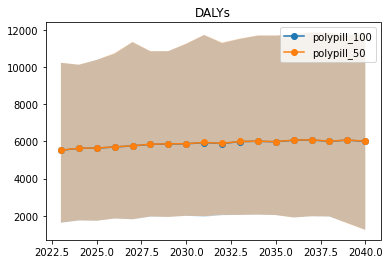

In [11]:
groups = daly_sum.groupby('scenario')
for name, group in groups: 
    plt.plot(group['year'], group['mean'], marker = 'o',label=name)
    plt.fill_between(group['year'], group['2.5%'], group['97.5%'], alpha = 0.3)
plt.title('DALYs')
plt.legend()

### All Cause Mortality Graphs

In [12]:
result_summary = (deaths
                      .groupby(['age', 'sex', 'year', 'scenario'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,polypill_100,13.48,0.0,85.925
1,25_to_29,female,2023,polypill_50,13.52,0.0,85.925
2,25_to_29,female,2024,polypill_100,13.60,0.0,74.325
3,25_to_29,female,2024,polypill_50,13.66,0.0,75.100
4,25_to_29,female,2025,polypill_100,12.40,0.0,64.900


In [13]:
%%capture 
from matplotlib.backends.backend_pdf import PdfPages # PDF package

with PdfPages('raw_mortality_counts_model8.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for year in result_summary.year.unique():
            plt.figure()
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o',label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.title(f'Raw death counts: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=1000)
            plt.grid()
            plt.legend()
            pdf.savefig(bbox_inches='tight')

#### All Cause Mortality Graph with Rate

In [14]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year', 'input_draw', 'scenario']).ptvalue.sum().reset_index()

per_time_group.head()

,age,sex,year,input_draw,scenario,ptvalue
0,25_to_29,female,2023,29,polypill_100,27442.683094
1,25_to_29,female,2023,29,polypill_50,27442.683094
2,25_to_29,female,2023,232,polypill_100,27756.911704
3,25_to_29,female,2023,232,polypill_50,27756.911704
4,25_to_29,female,2023,357,polypill_100,27623.370294


In [15]:
results_rate = deaths.groupby(['age', 'sex', 'year', 'input_draw', 'scenario']).value.sum().reset_index()
results_rate = pd.concat([results_rate, per_time_group.ptvalue], axis=1)
results_rate['mean_rate'] = results_rate['value'] / results_rate['ptvalue']
result_summary = (results_rate
                      .groupby(['age', 'sex', 'year', 'scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,polypill_100,0.002462,0.000927,0.007034
1,25_to_29,female,2023,polypill_50,0.002469,0.000927,0.007091
2,25_to_29,female,2024,polypill_100,0.002513,0.000891,0.006516
3,25_to_29,female,2024,polypill_50,0.002525,0.000891,0.006583
4,25_to_29,female,2025,polypill_100,0.002317,0.001120,0.005969


In [16]:
%%capture 
with PdfPages('acmr_model8.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for year in result_summary.year.unique():
            plt.figure() 
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o', label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.title(f'ACMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.4)
            plt.grid()
            plt.legend()
            pdf.savefig(bbox_inches='tight')

In [17]:
%%capture 
## Has age and year reversed, so looking at year trend by age group now. 
with PdfPages('acmr_by_year_model8.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for age in result_summary.age.unique():
            plt.figure() 
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.age==age)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['year'], group['mean'], marker='o', label=name)
                plt.fill_between(group['year'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.title(f'ACMR: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymin=0) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Cause Specific Mortality Graphs
#### Acute Stroke

In [18]:
deaths_cause = (deaths
               .groupby(['age', 'sex', 'year', 'cause', 'scenario'])
               .value.describe(percentiles=[.025, .975])
               .filter(['mean', '2.5%', '97.5%'])
               .reset_index())

acute = deaths_cause.loc[(deaths_cause['cause'] == 'acute_ischemic_stroke')].reset_index()

acute.head()

,index,age,sex,year,cause,scenario,mean,2.5%,97.5%
0,0,25_to_29,female,2023,acute_ischemic_stroke,polypill_100,2.6,0.0,16.725
1,1,25_to_29,female,2023,acute_ischemic_stroke,polypill_50,2.6,0.0,16.725
2,10,25_to_29,female,2024,acute_ischemic_stroke,polypill_100,3.7,0.0,17.625
3,11,25_to_29,female,2024,acute_ischemic_stroke,polypill_50,3.7,0.0,17.625
4,20,25_to_29,female,2025,acute_ischemic_stroke,polypill_100,2.3,0.0,12.650


In [19]:
death_rate_cause = deaths.groupby(['age', 'sex', 'year', 'input_draw', 'cause', 'scenario']).value.sum().reset_index()
acute_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_ischemic_stroke')].reset_index()
acute_rate.head()

,index,age,sex,year,input_draw,cause,scenario,value
0,0,25_to_29,female,2023,29,acute_ischemic_stroke,polypill_100,2.0
1,1,25_to_29,female,2023,29,acute_ischemic_stroke,polypill_50,2.0
2,10,25_to_29,female,2023,232,acute_ischemic_stroke,polypill_100,0.0
3,11,25_to_29,female,2023,232,acute_ischemic_stroke,polypill_50,0.0
4,20,25_to_29,female,2023,357,acute_ischemic_stroke,polypill_100,1.0


In [20]:
acute_rate_2 = pd.concat([acute_rate, per_time_group.ptvalue], axis=1)
acute_rate_2['mean_rate'] = acute_rate_2['value'] / acute_rate_2['ptvalue']

acute_rate_summary = (acute_rate_2
                      .groupby(['age', 'sex', 'year', 'scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_summary.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,polypill_100,0.000095,0.0,0.000611
1,25_to_29,female,2023,polypill_50,0.000095,0.0,0.000611
2,25_to_29,female,2024,polypill_100,0.000137,0.0,0.000652
3,25_to_29,female,2024,polypill_50,0.000137,0.0,0.000652
4,25_to_29,female,2025,polypill_100,0.000086,0.0,0.000472


In [21]:
%%capture 
with PdfPages('acute_stroke_csmr_model8.pdf') as pdf:
    for sex in acute_rate_summary.sex.unique():
        for year in acute_rate_summary.year.unique():
            plt.figure() 
            subdata = acute_rate_summary.loc[(acute_rate_summary.sex==sex) & (acute_rate_summary.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o', label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Acute Stroke CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.01)
            plt.grid()
            plt.ylabel('CSMR for Acute Stroke') 
            pdf.savefig(bbox_inches='tight')

#### Chronic Stroke

In [22]:
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate = pd.concat([chronic_rate, per_time_group.ptvalue], axis=1)
chronic_rate['mean_rate'] = chronic_rate['value'] / chronic_rate['ptvalue']
chronic_rate_summ = (chronic_rate
                      .groupby(['age', 'sex', 'year', 'scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

chronic_rate_summ

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,polypill_100,0.000000,0.000000,0.000000
1,25_to_29,female,2023,polypill_50,0.000000,0.000000,0.000000
2,25_to_29,female,2024,polypill_100,0.000000,0.000000,0.000000
3,25_to_29,female,2024,polypill_50,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
1076,95_plus,male,2039,polypill_100,0.008918,0.005878,0.013838
1077,95_plus,male,2039,polypill_50,0.008896,0.005182,0.013942
1078,95_plus,male,2040,polypill_100,0.007713,0.002720,0.011083
1079,95_plus,male,2040,polypill_50,0.007762,0.002747,0.011139


In [23]:
%%capture
with PdfPages('chronic_stroke_csmr_model8.pdf') as pdf:
    for sex in chronic_rate_summ.sex.unique():
        for year in chronic_rate_summ.year.unique():
            plt.figure() 
            subdata = chronic_rate_summ.loc[(chronic_rate_summ.sex==sex) & (chronic_rate_summ.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o', label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Chronic Stroke CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.03)
            plt.grid()
            plt.ylabel('CSMR for Chronic Stroke') 
            pdf.savefig(bbox_inches='tight')

#### Acute Myocardial Infarction

In [24]:
death_rate_cause.cause.unique()

array(['acute_ischemic_stroke', 'acute_myocardial_infarction',
       'chronic_ischemic_stroke', 'other_causes',
       'post_myocardial_infarction'], dtype=object)

In [25]:
acute_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction')].reset_index()
acute_MI_rate = pd.concat([acute_MI_rate, per_time_group.ptvalue], axis=1)
acute_MI_rate['mean_rate'] = acute_MI_rate['value'] / acute_MI_rate['ptvalue']
acute_MI_rate_summ = (acute_MI_rate
                      .groupby(['age', 'sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_MI_rate_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,polypill_100,0.001135,0.000008,0.004492
1,25_to_29,female,2023,polypill_50,0.001142,0.000008,0.004548
2,25_to_29,female,2024,polypill_100,0.000990,0.000045,0.003833
3,25_to_29,female,2024,polypill_50,0.001002,0.000045,0.003899
4,25_to_29,female,2025,polypill_100,0.000937,0.000119,0.003434


In [26]:
%%capture
with PdfPages('acute_MI_csmr_model8.pdf') as pdf:
    for sex in acute_MI_rate_summ.sex.unique():
        for year in acute_MI_rate_summ.year.unique():
            plt.figure() 
            subdata = acute_MI_rate_summ.loc[(acute_MI_rate_summ.sex==sex) & (acute_MI_rate_summ.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o', label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Acute MI CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.03)
            plt.grid()
            plt.ylabel('CSMR for Acute MI') 
            pdf.savefig(bbox_inches='tight')

We see some divergence with this one! Very small but something more than nothing. 

#### Post Myocaridal Infarction

In [27]:
post_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_rate = pd.concat([post_MI_rate, per_time_group.ptvalue], axis=1)
post_MI_rate['mean_rate'] = post_MI_rate['value'] / post_MI_rate['ptvalue']
post_MI_rate_summ = (post_MI_rate
                      .groupby(['age', 'sex', 'year', 'scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_rate_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,polypill_100,0.000285,0.000045,0.000903
1,25_to_29,female,2023,polypill_50,0.000285,0.000045,0.000903
2,25_to_29,female,2024,polypill_100,0.000348,0.000074,0.001194
3,25_to_29,female,2024,polypill_50,0.000348,0.000074,0.001194
4,25_to_29,female,2025,polypill_100,0.000371,0.000054,0.001210


In [28]:
%%capture
with PdfPages('post_MI_csmr_model8.pdf') as pdf:
    for sex in post_MI_rate_summ.sex.unique():
        for year in post_MI_rate_summ.year.unique():
            plt.figure() 
            subdata = post_MI_rate_summ.loc[(post_MI_rate_summ.sex==sex) & (post_MI_rate_summ.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o', label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Post MI CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.01)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

Again, we see more than nothing here. Might be more prominent for MI than stroke - I should check the RR values to see this makes sense 

### Angina

In [29]:
angina_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'angina')].reset_index()
angina_rate = pd.concat([angina_rate, per_time_group.ptvalue], axis=1)
angina_rate['mean_rate'] = angina_rate['value'] / angina_rate['ptvalue']
angina_rate_summ = (angina_rate
                      .groupby(['age', 'sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

angina_rate_summ.head()

scenario,age,sex,year


In [30]:
%%capture
with PdfPages('angina_csmr_model8.pdf') as pdf:
    for sex in angina_rate_summ.sex.unique():
        for year in angina_rate_summ.year.unique():
            plt.figure() 
            subdata = angina_rate_summ.loc[(angina_rate_summ.sex==sex) & (angina_rate_summ.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o', label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Angina CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.01)
            plt.grid()
            plt.ylabel('CSMR for Angina') 
            pdf.savefig(bbox_inches='tight')

### Excess Mortality rate

#### Post Myocardial Infarction

In [31]:
per_time_state = state_person_time.groupby(['age', 'sex', 'year', 'state', 'input_draw', 'scenario']).value.sum().reset_index()
per_time_state = per_time_state.rename(columns = {'value':'ptvalue'})
per_time_post_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_post_myocardial_infarction')].reset_index()

post_MI_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_emr = pd.concat([post_MI_emr, per_time_post_MI.ptvalue], axis=1)
post_MI_emr['mean_rate'] = post_MI_emr['value'] / post_MI_emr['ptvalue']
post_MI_emr_summ = (post_MI_emr
                      .groupby(['age', 'sex', 'year', 'scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_emr_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,polypill_100,0.042837,0.020931,0.075601
1,25_to_29,female,2023,polypill_50,0.042833,0.020931,0.075583
2,25_to_29,female,2024,polypill_100,0.046386,0.021381,0.071961
3,25_to_29,female,2024,polypill_50,0.046314,0.021381,0.071349
4,25_to_29,female,2025,polypill_100,0.051987,0.025002,0.133871


In [32]:
%%capture
with PdfPages('post_MI_emr_model8.pdf') as pdf:
    for sex in post_MI_emr_summ.sex.unique():
        for year in post_MI_emr_summ.year.unique():
            plt.figure() 
            subdata = post_MI_emr_summ.loc[(post_MI_emr_summ.sex==sex) & (post_MI_emr_summ.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o', label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Post MI EMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Prevalence 

#### Chronic + Acute Stroke

In [33]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
prev_acute = prev_acute.rename(columns = {'ptvalue':'value'})
prev_acute_rate = pd.concat([prev_acute, per_time_group.ptvalue], axis=1)
prev_acute_rate['rate']= prev_acute_rate['value'] / prev_acute_rate['ptvalue']
prev_acute_rate_sum = (prev_acute_rate
                 .groupby(['age', 'sex', 'year', 'scenario'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

prev_acute_rate_sum.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,polypill_100,0.000301,0.000003,0.001484
1,25_to_29,female,2023,polypill_50,0.000301,0.000003,0.001487
2,25_to_29,female,2024,polypill_100,0.000294,0.000003,0.001409
3,25_to_29,female,2024,polypill_50,0.000295,0.000003,0.001414
4,25_to_29,female,2025,polypill_100,0.000281,0.000007,0.001375


In [34]:
%%capture
with PdfPages('acute_stroke_prev_model8.pdf') as pdf:
    for sex in prev_acute_rate_sum.sex.unique():
        for year in prev_acute_rate_sum.year.unique():
            plt.figure() 
            subdata = prev_acute_rate_sum.loc[(prev_acute_rate_sum.sex==sex) & (prev_acute_rate_sum.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o', label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Prevalence Rate of Acute Ischemic Stroke: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [35]:
prev_chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
prev_chronic = prev_chronic.rename(columns = {'ptvalue':'value'})
prev_chronic_rate = pd.concat([prev_chronic, per_time_group.ptvalue], axis=1)
prev_chronic_rate['rate']= prev_chronic_rate['value'] / prev_chronic_rate['ptvalue']
prev_chronic_rate_sum = (prev_chronic_rate
                 .groupby(['age', 'sex', 'year', 'scenario'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [36]:
%%capture
with PdfPages('chronic_stroke_prev_model8.pdf') as pdf:
    for sex in prev_chronic_rate_sum.sex.unique():
        for year in prev_chronic_rate_sum.year.unique():
            plt.figure() 
            subdata = prev_chronic_rate_sum.loc[(prev_chronic_rate_sum.sex==sex) & (prev_chronic_rate_sum.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o', label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Prevalence Rate of Chronic Ischemic Stroke: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Myocardial Infarction

In [37]:
prev_acute_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_acute_myocardial_infarction')].reset_index()
prev_acute_MI = prev_acute_MI.rename(columns = {'ptvalue':'value'})
prev_acute_MI = pd.concat([prev_acute_MI, per_time_group.ptvalue], axis=1)
prev_acute_MI['rate']= prev_acute_MI['value'] / prev_acute_MI['ptvalue']
prev_acute_MI_summ = (prev_acute_MI
                 .groupby(['age', 'sex', 'year', 'scenario'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,polypill_100,0.000400,0.000038,0.001552
1,25_to_29,female,2023,polypill_50,0.000403,0.000038,0.001566
2,25_to_29,female,2024,polypill_100,0.000361,0.000049,0.001387
3,25_to_29,female,2024,polypill_50,0.000364,0.000049,0.001407
4,25_to_29,female,2025,polypill_100,0.000350,0.000051,0.001337


In [38]:
%%capture
with PdfPages('acute_mi_prev_model8.pdf') as pdf:
    for sex in prev_acute_MI_summ.sex.unique():
        for year in prev_acute_MI_summ.year.unique():
            plt.figure() 
            subdata = prev_acute_MI_summ.loc[(prev_acute_MI_summ.sex==sex) & (prev_acute_MI_summ.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o', label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Prevalence Rate of Acute MI: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [39]:
prev_post_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_post_myocardial_infarction')].reset_index()
prev_post_MI = prev_post_MI.rename(columns = {'ptvalue':'value'})
prev_post_MI = pd.concat([prev_post_MI, per_time_group.ptvalue], axis=1)
prev_post_MI['rate']= prev_post_MI['value'] / prev_post_MI['ptvalue']
prev_post_MI_summ = (prev_post_MI
                 .groupby(['age', 'sex', 'year','scenario'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,polypill_100,0.006755,0.001454,0.021076
1,25_to_29,female,2023,polypill_50,0.006753,0.001454,0.021064
2,25_to_29,female,2024,polypill_100,0.007454,0.001492,0.023399
3,25_to_29,female,2024,polypill_50,0.007458,0.001492,0.023411
4,25_to_29,female,2025,polypill_100,0.008009,0.001497,0.024183


In [40]:
%%capture
with PdfPages('post_MI_prev_model8.pdf') as pdf:
    for sex in prev_post_MI_summ.sex.unique():
        for year in prev_post_MI_summ.year.unique():
            plt.figure() 
            subdata = prev_post_MI_summ.loc[(post_MI_rate_summ.sex==sex) & (prev_post_MI_summ.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o', label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Post MI Prevalence: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.1)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Incidence of First Time Acute Ischemic Stroke

In [41]:
tran.transition.unique()

array(['ischemic_stroke_acute_ischemic_stroke_to_chronic_ischemic_stroke',
       'ischemic_stroke_chronic_ischemic_stroke_to_acute_ischemic_stroke',
       'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke',
       'myocardial_infarction_acute_myocardial_infarction_to_post_myocardial_infarction',
       'myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction',
       'myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction'],
      dtype=object)

In [42]:
tran_sum = (tran
                 .groupby(['age', 'sex', 'year', 'transition','scenario'])
                 .value.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_sum_stroke = tran_sum.loc[(tran_sum['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_sum_stroke.head()

,index,age,sex,year,transition,scenario,mean,2.5%,97.5%
0,4,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke...,polypill_100,44.7,1.225,250.50
1,5,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke...,polypill_50,44.7,1.225,250.50
2,16,25_to_29,female,2024,ischemic_stroke_susceptible_to_ischemic_stroke...,polypill_100,40.4,1.000,225.00
3,17,25_to_29,female,2024,ischemic_stroke_susceptible_to_ischemic_stroke...,polypill_50,40.6,1.000,226.55
4,28,25_to_29,female,2025,ischemic_stroke_susceptible_to_ischemic_stroke...,polypill_100,39.6,2.225,214.15


In [43]:
per_time_sus_stroke = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_susceptible_to_ischemic_stroke')].reset_index()
per_time_sus_stroke.head()

,index,age,sex,year,state,input_draw,scenario,ptvalue
0,40,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,29,polypill_100,27136.657084
1,41,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,29,polypill_50,27136.657084
2,42,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,232,polypill_100,27616.010951
3,43,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,232,polypill_50,27616.010951
4,44,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,357,polypill_100,27449.965777


In [44]:
tran_rate = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw', 'scenario']).value.sum().reset_index()
tran_rate = tran_rate.loc[(tran_rate['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_rate = pd.concat([tran_rate, per_time_group.ptvalue], axis=1)
tran_rate['rate']= tran_rate['value'] / tran_rate['ptvalue']
tran_rate_sum = (tran_rate
                 .groupby(['age', 'sex', 'year', 'scenario'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_sum.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,polypill_100,0.001633,0.000044,0.009155
1,25_to_29,female,2023,polypill_50,0.001633,0.000044,0.009155
2,25_to_29,female,2024,polypill_100,0.001493,0.000037,0.008321
3,25_to_29,female,2024,polypill_50,0.001501,0.000037,0.008379
4,25_to_29,female,2025,polypill_100,0.001479,0.000082,0.007995


In [45]:
%%capture
with PdfPages('acute_stroke_inc_model8.pdf') as pdf:
    for sex in tran_rate_sum.sex.unique():
        for age in tran_rate_sum.age.unique():
            plt.figure() 
            subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.age==age)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['year'], group['mean'], marker='o', label=name)
                plt.fill_between(group['year'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Acute Stroke Incidence: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [46]:
%%capture
with PdfPages('acute_stroke_inc_byyear_model8.pdf') as pdf:
    for sex in tran_rate_sum.sex.unique():
        for year in tran_rate_sum.year.unique():
            plt.figure() 
            subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.year==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['age'], group['mean'], marker='o', label=name)
                plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Acute Stroke Incidence: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Incidence of Acute Myocardial Infraction 

In [47]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["myocardial_infarction_acute_myocardial_infarction", "myocardial_infarction_post_myocardial_infarction", "myocardial_infarction_susceptible_to_myocardial_infarction"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['myocardial_infarction_susceptible_to_myocardial_infarction','myocardial_infarction_post_myocardial_infarction']))].reset_index()
tran_rate_MI = tran.loc[(tran['transition'].isin(['myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction','myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw', 'scenario']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols).sum() / per_time_sus_MI.groupby(groupby_cols).sum()
tran_MI_summ = (tran_rate_MI_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_MI_summ.head()

mean      2.5%     97.5%
age      sex    year scenario                                  
25_to_29 female 2023 polypill_100  0.005148  0.000485  0.020039
                     polypill_50   0.005195  0.000485  0.020231
                2024 polypill_100  0.004783  0.000629  0.018700
                     polypill_50   0.004824  0.000629  0.018957
                2025 polypill_100  0.004643  0.000642  0.017695

In [61]:
%%capture
with PdfPages('acute_MI_inc_model8.pdf') as pdf:
    for sex in tran_MI_summ.index.get_level_values('sex').unique():
        for year in tran_MI_summ.index.get_level_values('year').unique():
            plt.figure() 
            subdata = tran_MI_summ.loc[(tran_MI_summ.index.get_level_values('sex')==sex) & (tran_MI_summ.index.get_level_values('year')==year)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group.index.get_level_values('age'), group['mean'], marker='o', label=name)
                plt.fill_between(group.index.get_level_values('age'), group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Acute MI Incidence: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            plt.ylim(0,0.04)
            pdf.savefig(bbox_inches='tight')

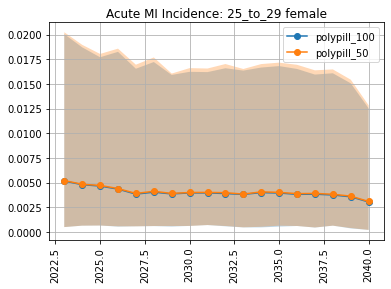

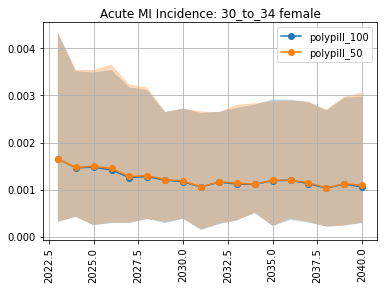

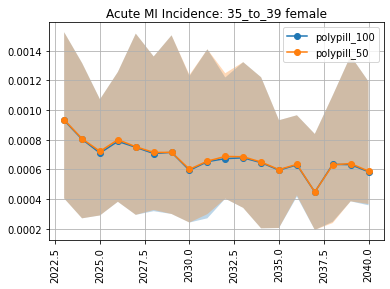

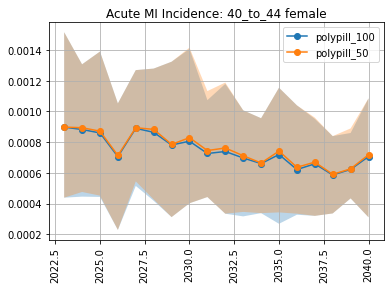

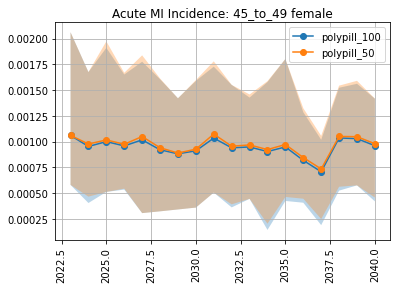

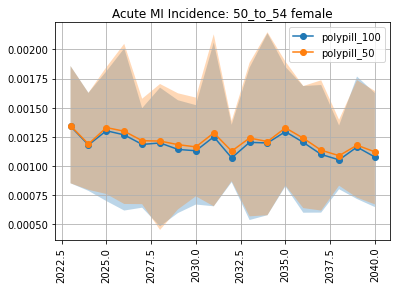

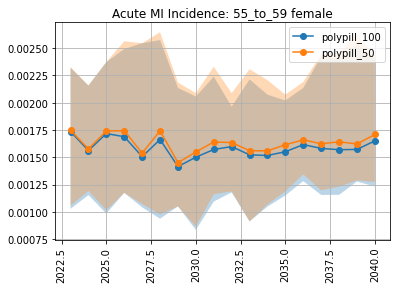

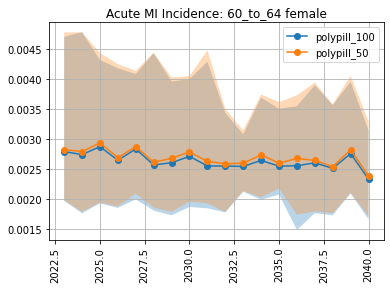

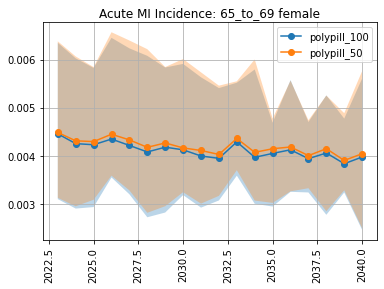

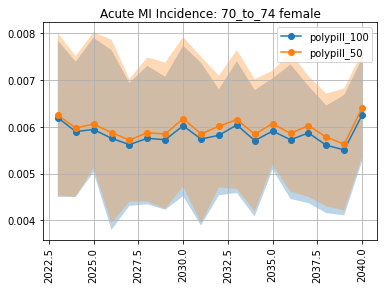

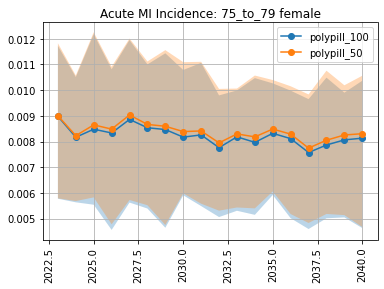

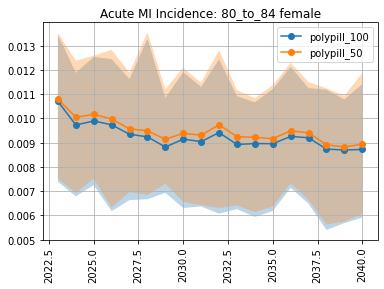

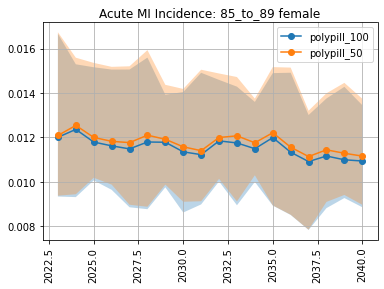

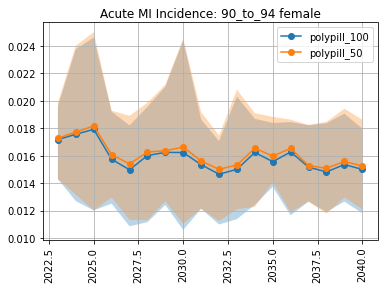

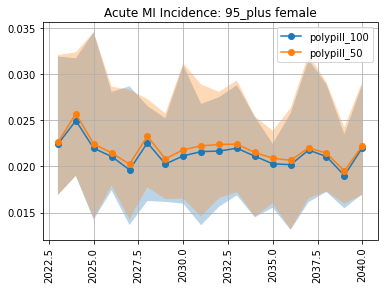

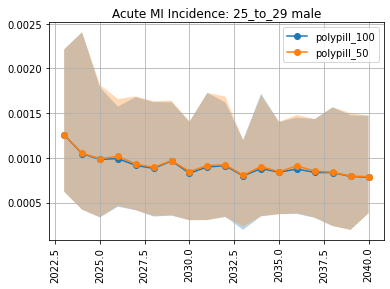

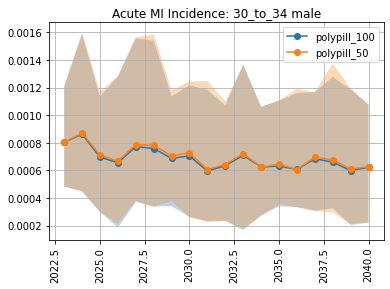

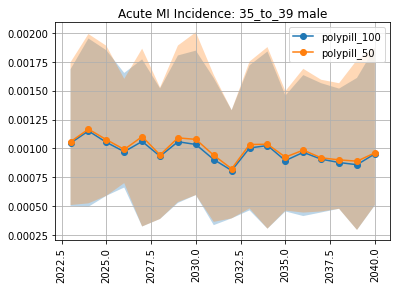

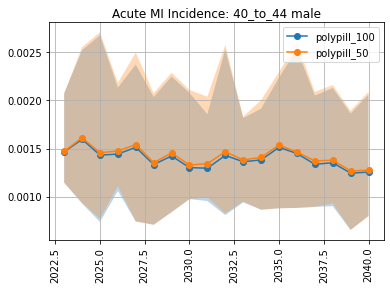

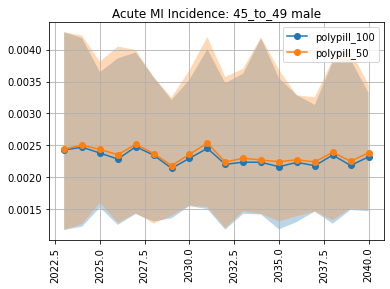

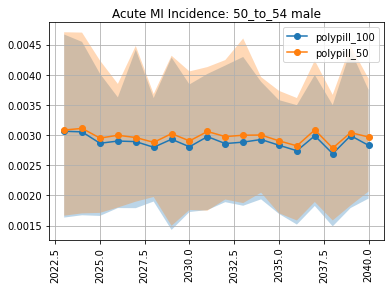

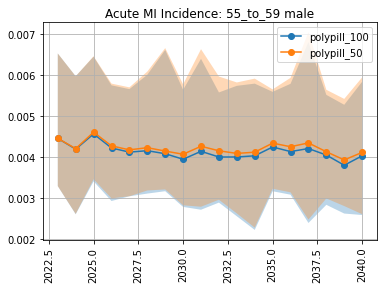

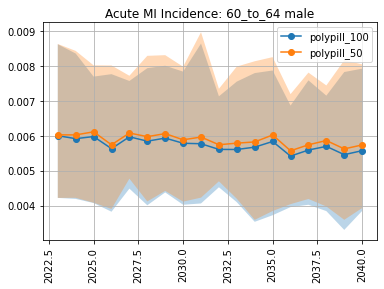

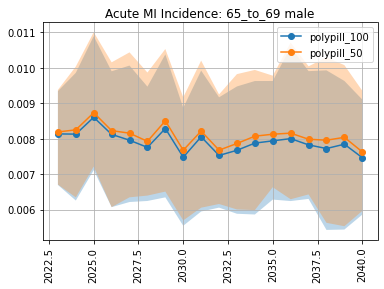

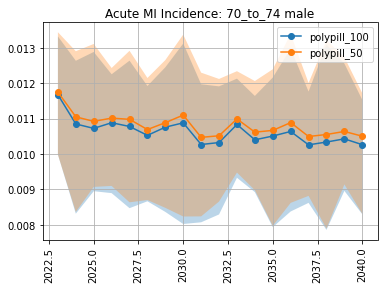

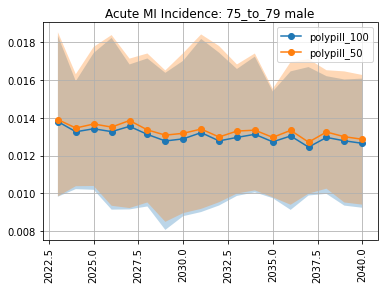

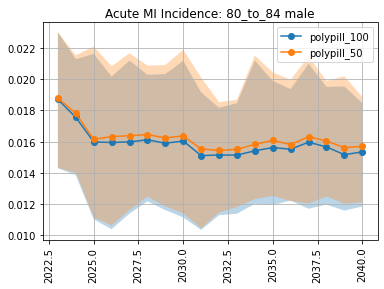

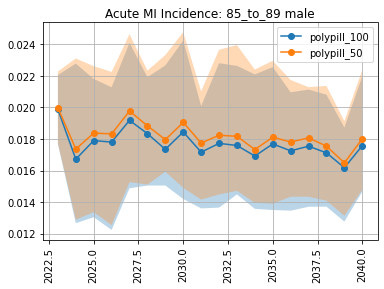

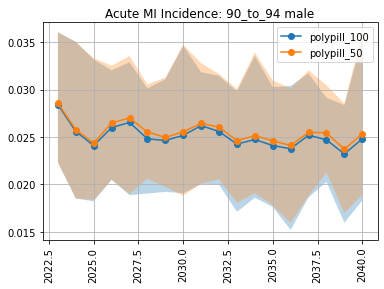

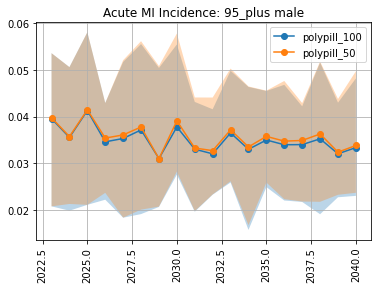

In [59]:
#%%capture
with PdfPages('acute_MI_inc_byyear_model8.pdf') as pdf:
    for sex in tran_MI_summ.index.get_level_values('sex').unique():
        for age in tran_MI_summ.index.get_level_values('age').unique():
            plt.figure() 
            subdata = tran_MI_summ.loc[(tran_MI_summ.index.get_level_values('sex')==sex) & (tran_MI_summ.index.get_level_values('age')==age)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group.index.get_level_values('year'), group['mean'], marker='o', label=name)
                plt.fill_between(group.index.get_level_values('year'), group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Acute MI Incidence: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### LDL-C Testing - Total Exposure by age/year

In [50]:
risk_exp = pd.read_csv(sim_results_dir + 'risk_exposure_time.csv')
ldl = risk_exp.loc[risk_exp['risk']=='high_ldl_cholesterol']
ldl_summ = (ldl
                .groupby(['age', 'sex', 'year','scenario'])
                .value.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
ldl_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,polypill_100,75306.015090,69465.246439,81787.517912
1,25_to_29,female,2023,polypill_50,75305.857652,69465.246439,81786.297768
2,25_to_29,female,2024,polypill_100,74685.809257,69025.750047,80972.496511
3,25_to_29,female,2024,polypill_50,74684.947511,69025.750047,80966.077850
4,25_to_29,female,2025,polypill_100,74167.561053,68565.096335,80322.264727


In [51]:
ldl_rate = ldl.groupby(['age','sex','year','input_draw','scenario']).value.sum().reset_index()
ldl_rate = pd.concat([ldl_rate, per_time_group.ptvalue], axis=1)
ldl_rate['ldl_rate'] = ldl_rate['value'] / ldl_rate['ptvalue']
ldl_rate_summ = (ldl_rate
                .groupby(['age', 'sex', 'year','scenario'])
                .ldl_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
ldl_rate_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,polypill_100,2.742535,2.516553,2.994731
1,25_to_29,female,2023,polypill_50,2.742533,2.516553,2.994713
2,25_to_29,female,2024,polypill_100,2.751738,2.525365,3.003965
3,25_to_29,female,2024,polypill_50,2.751732,2.525365,3.003922
4,25_to_29,female,2025,polypill_100,2.761226,2.537069,3.013360


In [52]:
%%capture
with PdfPages('ldl_exposure_model8.pdf') as pdf:
    for sex in ldl_rate_summ.sex.unique():
        for age in ldl_rate_summ.age.unique():
            plt.figure() 
            subdata = ldl_rate_summ.loc[(ldl_rate_summ.sex==sex) & (ldl_rate_summ.age==age)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['year'], group['mean'], marker='o', label=name)
                plt.fill_between(group['year'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'LDL Exposure: {sex} in {age}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### High SBP Risk Factor Testing 

In [53]:
sbp = risk_exp.loc[risk_exp['risk']=='high_systolic_blood_pressure']
sbp_rate = sbp.groupby(['age','sex','year','input_draw','scenario']).value.sum().reset_index()
sbp_rate = pd.concat([sbp_rate, per_time_group.ptvalue], axis=1)
sbp_rate['ldl_rate'] = sbp_rate['value'] / sbp_rate['ptvalue']
sbp_rate_summ = (sbp_rate
                .groupby(['age', 'sex', 'year','scenario'])
                .ldl_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
sbp_rate_summ.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,polypill_100,114.469441,106.636460,120.111864
1,25_to_29,female,2023,polypill_50,114.477048,106.637702,120.126016
2,25_to_29,female,2024,polypill_100,114.361880,106.605159,119.957092
3,25_to_29,female,2024,polypill_50,114.385753,106.609444,120.005201
4,25_to_29,female,2025,polypill_100,114.286605,106.551845,119.844828


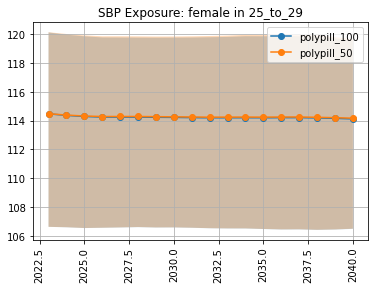

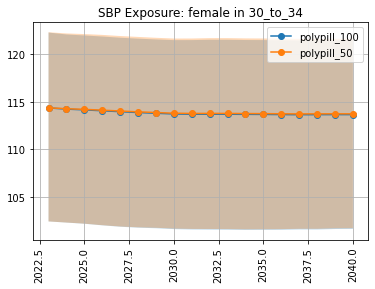

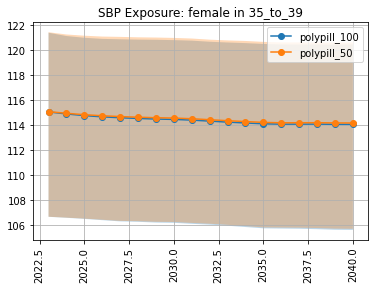

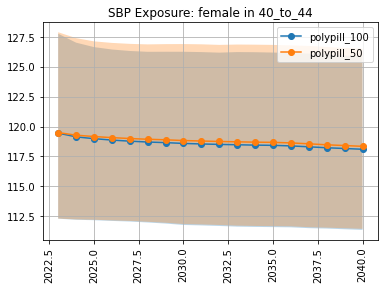

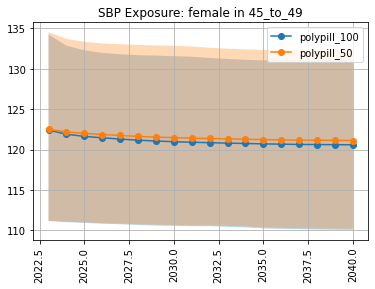

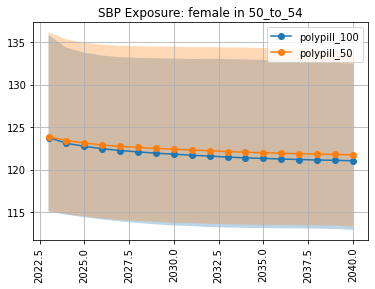

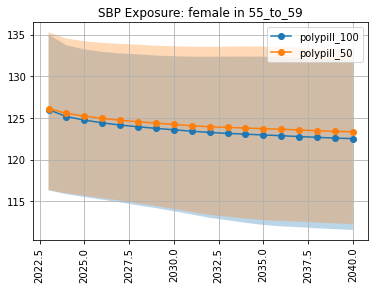

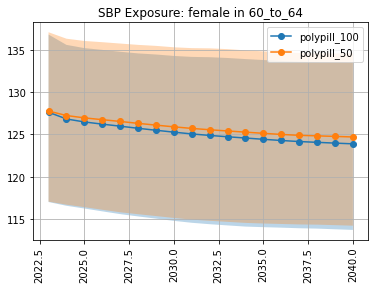

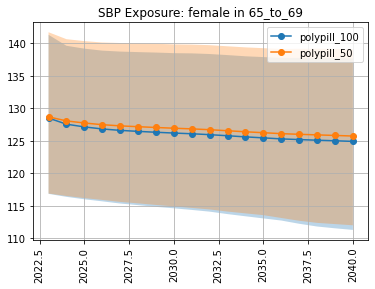

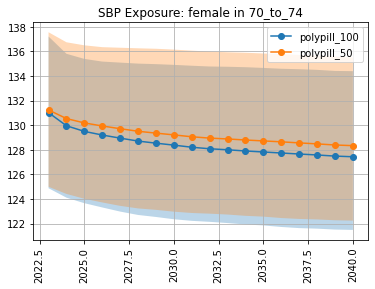

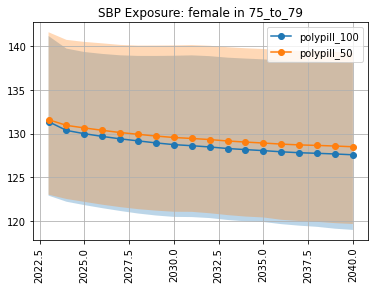

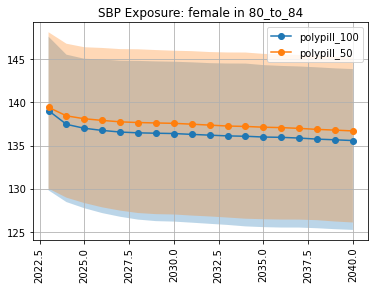

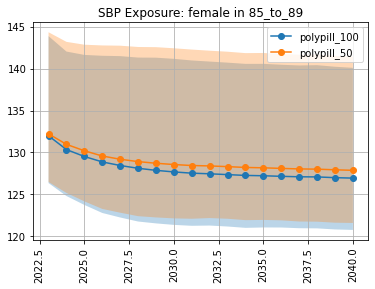

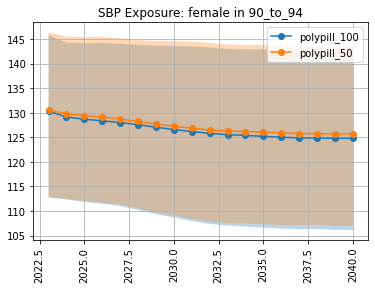

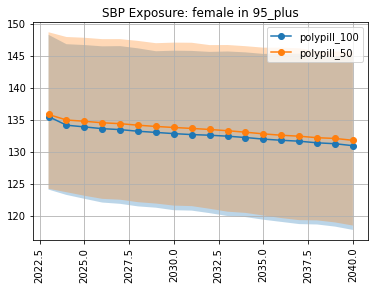

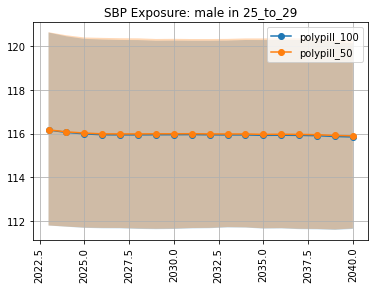

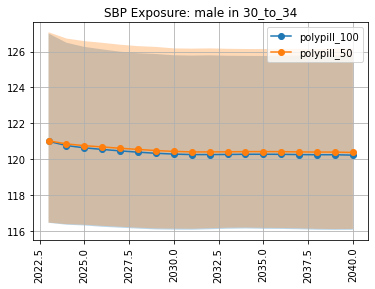

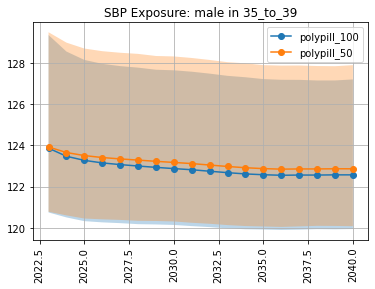

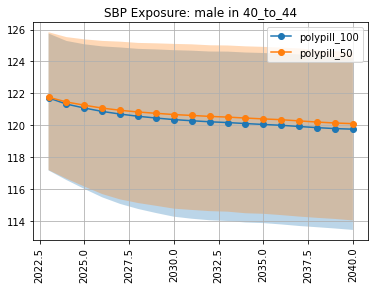

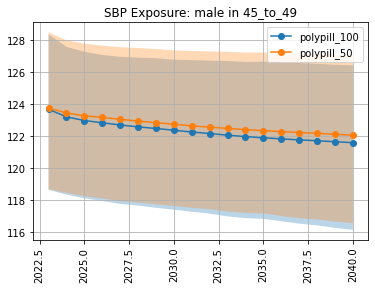

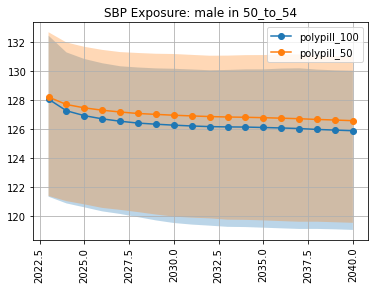

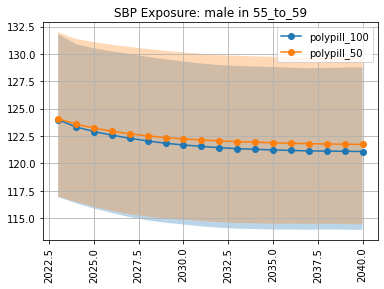

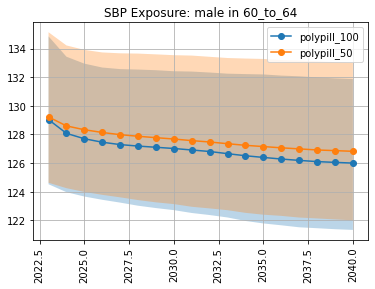

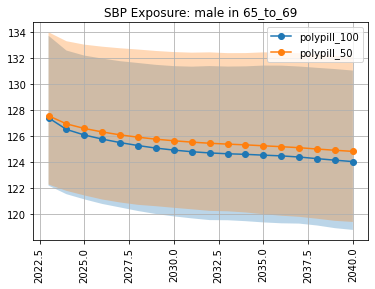

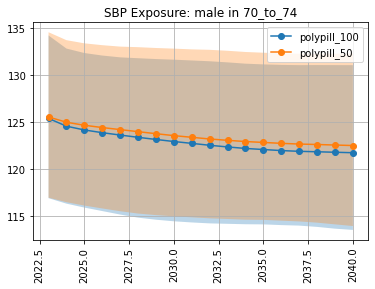

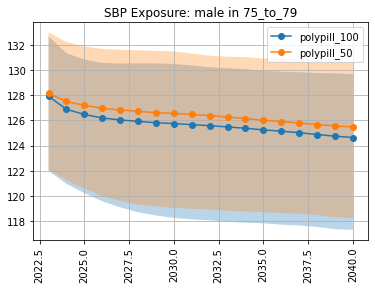

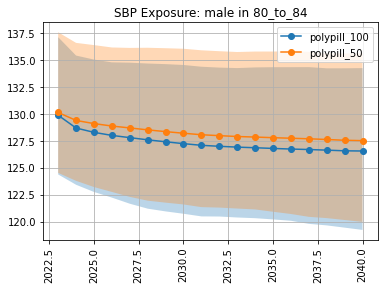

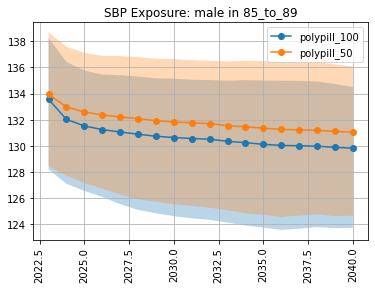

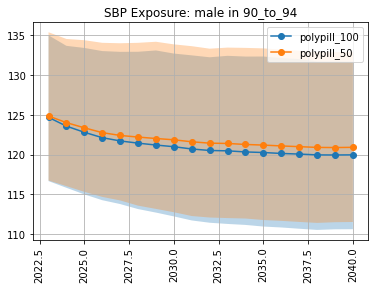

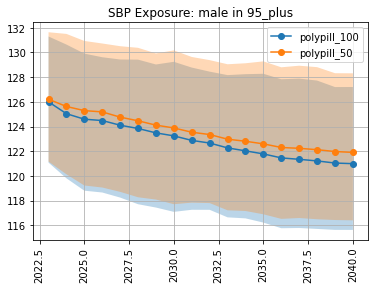

In [58]:
#%%capture
with PdfPages('sbp_exposure_model8.pdf') as pdf:
    for sex in sbp_rate_summ.sex.unique():
        for age in sbp_rate_summ.age.unique():
            plt.figure() 
            subdata = sbp_rate_summ.loc[(sbp_rate_summ.sex==sex) & (sbp_rate_summ.age==age)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['year'], group['mean'], marker='o', label=name)
                plt.fill_between(group['year'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'SBP Exposure: {sex} in {age}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### People on the Intervention

In [55]:
outreach = pd.read_csv(sim_results_dir + 'intervention_person_time.csv')
outreach = outreach.loc[outreach.intervention == 'yes']
outreach = (outreach
                .groupby(['age', 'sex', 'year','scenario'])
                .value.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

outreach.head()

,age,sex,year,scenario,mean,2.5%,97.5%
0,25_to_29,female,2023,polypill_100,29.935661,0.0,111.083915
1,25_to_29,female,2023,polypill_50,14.653525,0.0,52.644216
2,25_to_29,female,2024,polypill_100,110.976591,0.0,426.401095
3,25_to_29,female,2024,polypill_50,55.497878,0.0,215.306776
4,25_to_29,female,2025,polypill_100,144.450103,0.0,566.740315


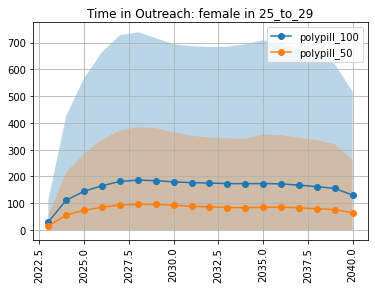

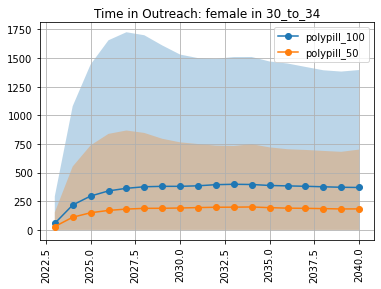

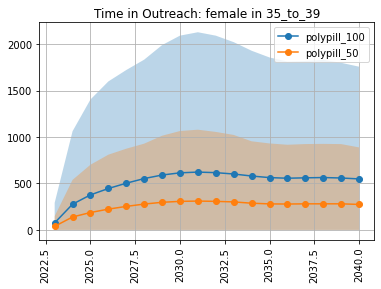

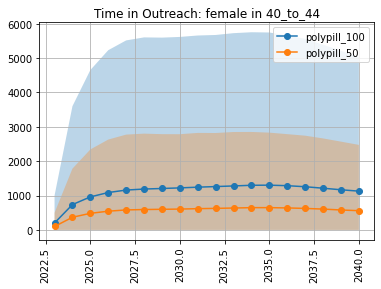

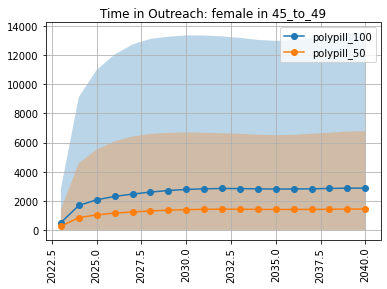

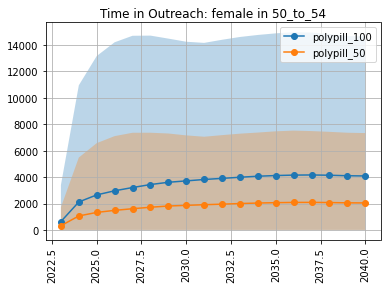

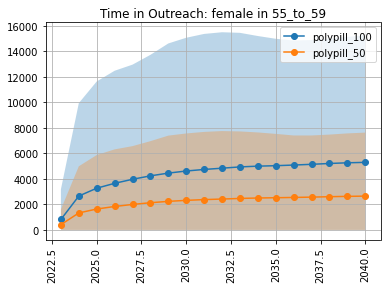

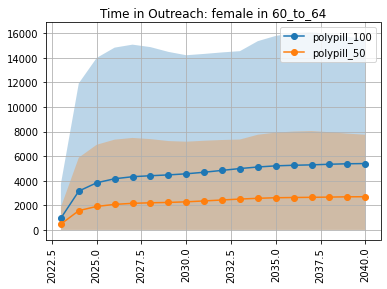

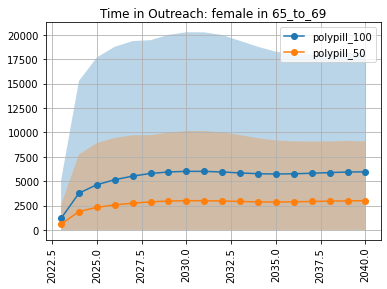

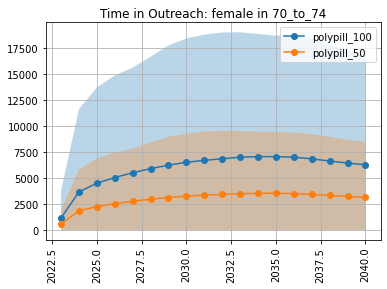

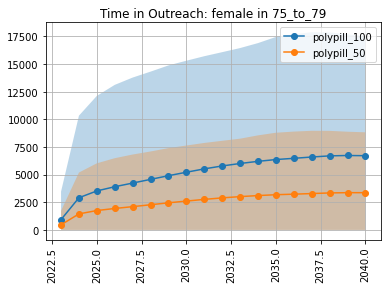

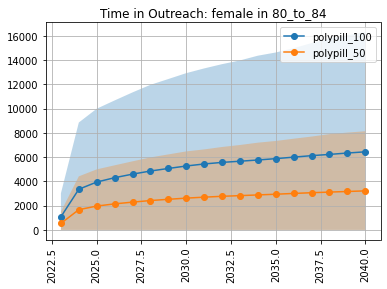

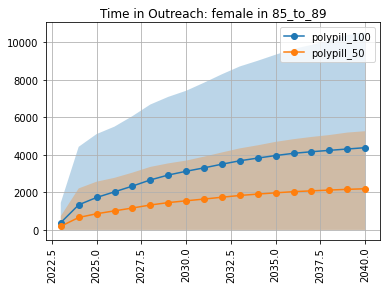

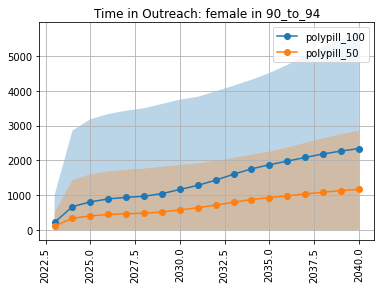

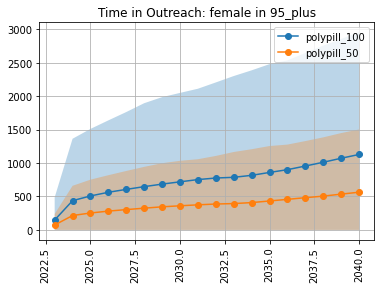

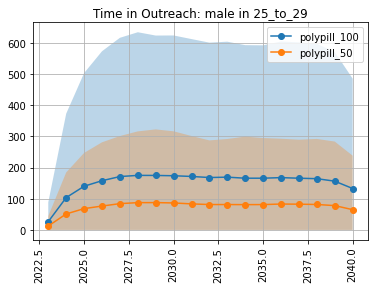

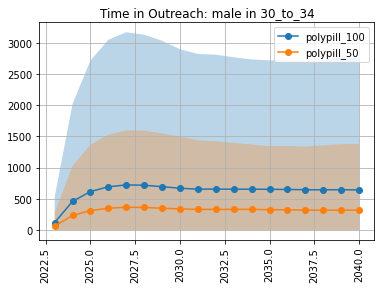

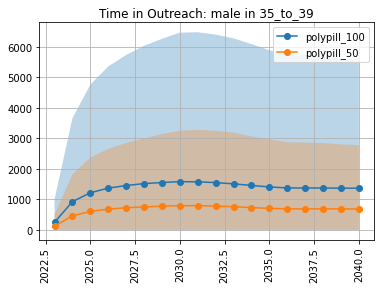

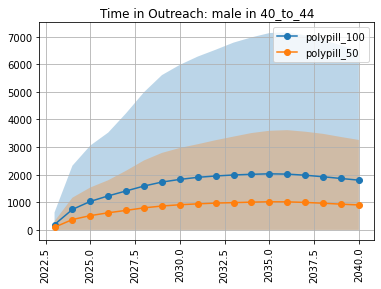

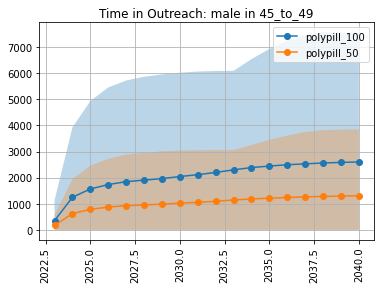

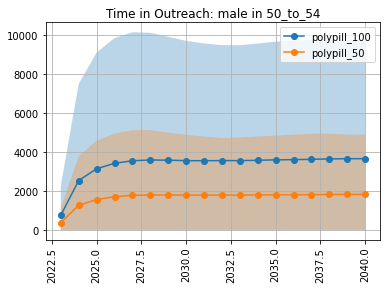

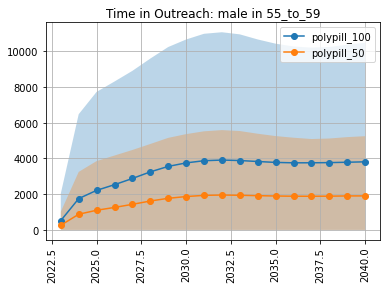

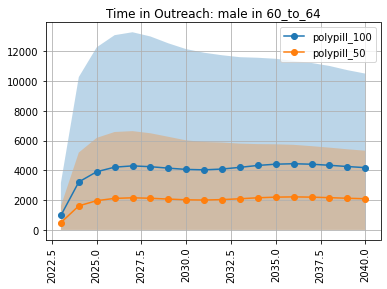

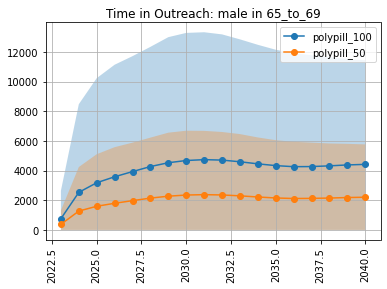

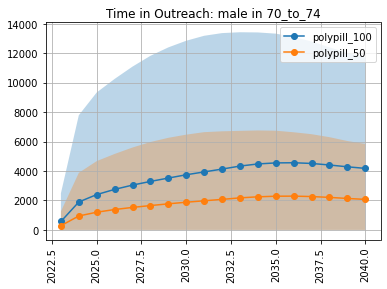

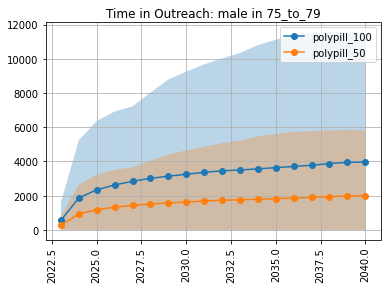

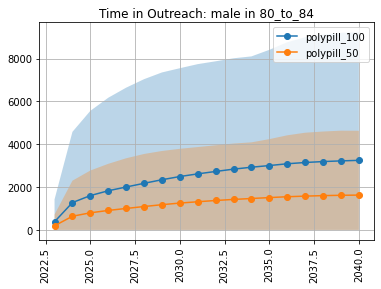

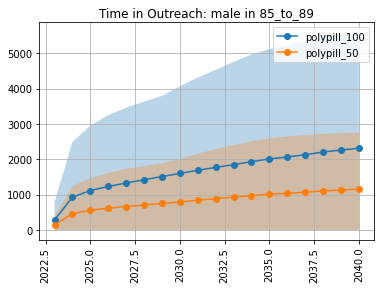

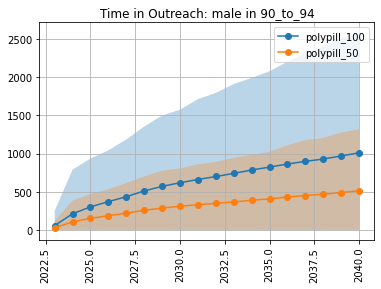

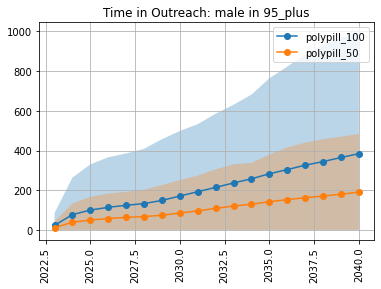

In [57]:
#%%capture
with PdfPages('outreach_time_model8.pdf') as pdf:
    for sex in outreach.sex.unique():
        for age in outreach.age.unique():
            plt.figure() 
            subdata = outreach.loc[(outreach.sex==sex) & (outreach.age==age)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['year'], group['mean'], marker='o', label=name)
                plt.fill_between(group['year'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Time in Outreach: {sex} in {age}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')